In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

# Constants and parameters
a1, b1 = 0.40095, 0.0428023
a_bar, b_bar = 0.688536, 0.10793
lambda_val = 0.5
resf = 10
rv = 5
epsilon = 5
K1, K2 = 1, 4.24

In [2]:
# Initial conditions
X1inic = np.array([-2, 10, 5])
X2inic = np.array([-10, 0, 5])
X3inic = np.array([-2, -10, 5])
initial_state = np.concatenate([X1inic, X2inic, X3inic, np.zeros(9)])

In [3]:
# Time points
t0, t1, dt = 0, 200, 0.01  # Adjust the time range and step size as needed
t_vals = np.arange(t0, t1 + dt, dt)

In [4]:
t_vals.shape

(20001,)

In [5]:
def reference_signal(t):
    # Define the reference signal for the target spherical volume
    x_d = 10 * np.cos(t)
    y_d = 10 * np.sin(t)
    z_d = np.minimum(10, 1 * t)  # Z grows continuously until reaching a value of 10, then remains constant
    return np.array([x_d, y_d, z_d])

In [6]:
def repulsion_force(xi, yi, zi, xj, yj, zj, rv):
    distance = np.sqrt((xi - xj)**2 + (yi - yj)**2 + (zi - zj)**2)

    if distance < rv and distance != 0:
        direction_vector = np.array([xi - xj, yi - yj, zi - zj])
        unit_vector = direction_vector / np.linalg.norm(direction_vector)

        repulsion_force_magnitude = (rv - distance) ** 2 / distance
        repulsion_force_vector = repulsion_force_magnitude * unit_vector

        fr_x, fr_y, fr_z = repulsion_force_vector
    else:
        fr_x, fr_y, fr_z = 0.0, 0.0, 0.0

    return fr_x, fr_y, fr_z

In [7]:
def saturation(value, epsilon):
    if np.abs(value) > epsilon:
        return np.sign(value)
    else:
        return value / epsilon

In [61]:
prev_error1 = np.zeros(3)
prev_error2 = np.zeros(3)
prev_error3 = np.zeros(3)


def system_dynamics(y, t, a1, b1, a_bar, b_bar, lambda_val, resf, rv, epsilon, K1, K2, prev_error1, prev_error2, prev_error3):

    xi1, yi1, zi1, xi2, yi2, zi2, xi3, yi3, zi3, x_dot1, y_dot1, z_dot1, x_dot2, y_dot2, z_dot2, x_dot3, y_dot3, z_dot3  = y[:18]
    fr_x1, fr_y1, fr_z1 = 0, 0, 0
    fr_x2, fr_y2, fr_z2 = 0, 0, 0
    fr_x3, fr_y3, fr_z3 = 0, 0, 0

    # print(prev_error1)

    # Calculate repulsion forces
    for neighbor in [(xi2, yi2, zi2), (xi3, yi3, zi3)]:
        fr_x, fr_y, fr_z = repulsion_force(xi1, yi1, zi1, *neighbor, rv)
        fr_x1 += fr_x
        fr_y1 += fr_y
        fr_z1 += fr_z

    for neighbor in [(xi1, yi1, zi1), (xi3, yi3, zi3)]:
        fr_x, fr_y, fr_z = repulsion_force(xi2, yi2, zi2, *neighbor, rv)
        fr_x2 += fr_x
        fr_y2 += fr_y
        fr_z2 += fr_z

    for neighbor in [(xi1, yi1, zi1), (xi2, yi2, zi2)]:
        fr_x, fr_y, fr_z = repulsion_force(xi3, yi3, zi3, *neighbor, rv)
        fr_x3 += fr_x
        fr_y3 += fr_y
        fr_z3 += fr_z


    # Perturbation forces (set to zero for now)
    fd_x1, fd_y1, fd_z1 = 0, 0, 0
    fd_x2, fd_y2, fd_z2 = 0, 0, 0
    fd_x3, fd_y3, fd_z3 = 0, 0, 0

    # # Perturbation forces
    fd_x1 = 10 + 10 * np.sin(0.2 * np.pi * (t - 80)) * (t >= 80)
    fd_y1 = 5 + 5 * np.sin(0.2 * np.pi * (t - 140)) * (t >= 140)

    fd_x2 = 10 + 10 * np.sin(0.2 * np.pi * (t - 80)) * (t >= 80)
    fd_y2 = 5 + 5 * np.sin(0.2 * np.pi * (t - 140)) * (t >= 140)

    fd_x3 = 10 + 10 * np.sin(0.2 * np.pi * (t - 80)) * (t >= 80)
    fd_y3 = 5 + 5 * np.sin(0.2 * np.pi * (t - 140)) * (t >= 140)

    fd_z1, fd_z2, fd_z3 = 0, 0, 0



    # Calculate sliding surface and control signals
    error1 = np.array([xi1, yi1, zi1]) - reference_signal(t)
    error2 = np.array([xi2, yi2, zi2]) - reference_signal(t)
    error3 = np.array([xi3, yi3, zi3]) - reference_signal(t)

    # Calculate error_dot
    error_dot1 = (error1 - prev_error1) / dt
    error_dot2 = (error2 - prev_error2) / dt
    error_dot3 = (error3 - prev_error3) / dt

    # print(error1, error2, error3)

    # Update previous errors for the next iteration
    prev_error1 = error1.copy()
    prev_error2 = error2.copy()
    prev_error3 = error3.copy()

    # Calculate sliding surface and control signals
    s_surface1 = lambda_val * error1 + error_dot1
    s_surface2 = lambda_val * error2 + error_dot2
    s_surface3 = lambda_val * error3 + error_dot3

    # Sliding mode control with saturation
    u_x1 = -K1 * s_surface1[0] - K2 * s_surface1[0] / np.linalg.norm(s_surface1) * saturation(s_surface1[0], epsilon)
    u_y1 = -K1 * s_surface1[1] - K2 * s_surface1[1] / np.linalg.norm(s_surface1) * saturation(s_surface1[1], epsilon)
    u_z1 = -K1 * s_surface1[2] - K2 * s_surface1[2] / np.linalg.norm(s_surface1) * saturation(s_surface1[2], epsilon)

    u_x2 = -K1 * s_surface2[0] - K2 * s_surface2[0] / np.linalg.norm(s_surface2) * saturation(s_surface2[0], epsilon)
    u_y2 = -K1 * s_surface2[1] - K2 * s_surface2[1] / np.linalg.norm(s_surface2) * saturation(s_surface2[1], epsilon)
    u_z2 = -K1 * s_surface2[2] - K2 * s_surface2[2] / np.linalg.norm(s_surface2) * saturation(s_surface2[2], epsilon)

    u_x3 = -K1 * s_surface3[0] - K2 * s_surface3[0] / np.linalg.norm(s_surface3) * saturation(s_surface3[0], epsilon)
    u_y3 = -K1 * s_surface3[1] - K2 * s_surface3[1] / np.linalg.norm(s_surface3) * saturation(s_surface3[1], epsilon)
    u_z3 = -K1 * s_surface3[2] - K2 * s_surface3[2] / np.linalg.norm(s_surface3) * saturation(s_surface3[2], epsilon)

    # Dynamics equations
    dx1dt = x_dot1
    dy1dt = y_dot1
    dz1dt = z_dot1
    dvx1dt = -a1 * x_dot1 + b1 * (u_x1 + fr_x1 + fd_x1)
    dvy1dt = -a1 * y_dot1 + b1 * (u_y1 + fr_y1 + fd_y1)
    dvz1dt = -a_bar * z_dot1 + b_bar * (u_z1 + fr_z1 + fd_z1)

    dx2dt = x_dot2
    dy2dt = y_dot2
    dz2dt = z_dot2
    dvx2dt = -a1 * x_dot2 + b1 * (u_x2 + fr_x2 + fd_x2)
    dvy2dt = -a1 * y_dot2 + b1 * (u_y2 + fr_y2 + fd_y2)
    dvz2dt = -a_bar * z_dot2 + b_bar * (u_z2 + fr_z2 + fd_z2)

    dx3dt = x_dot3
    dy3dt = y_dot3
    dz3dt = z_dot3
    dvx3dt = -a1 * x_dot3 + b1 * (u_x3 + fr_x3 + fd_x3)
    dvy3dt = -a1 * y_dot3 + b1 * (u_y3 + fr_y3 + fd_y3)
    dvz3dt = -a_bar * z_dot3 + b_bar * (u_z3 + fr_z3 + fd_z3)


    return [dx1dt, dy1dt, dz1dt, dx2dt, dy2dt, dz2dt, dx3dt, dy3dt, dz3dt,
            dvx1dt, dvy1dt, dvz1dt, dvx2dt, dvy2dt, dvz2dt, dvx3dt, dvy3dt, dvz3dt]



run this when perturbation is off

In [54]:
# Integrate the system using odeint
solution = odeint(system_dynamics, initial_state, t_vals, args=(a1, b1, a_bar, b_bar, lambda_val, resf, rv, epsilon, K1, K2, prev_error1, prev_error2, prev_error3))

# Extract results
xi1, yi1, zi1, xi2, yi2, zi2, xi3, yi3, zi3, _, _, _, _, _, _, _, _, _ = solution.T


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


Plot with perturbation

Plots for without perturbation

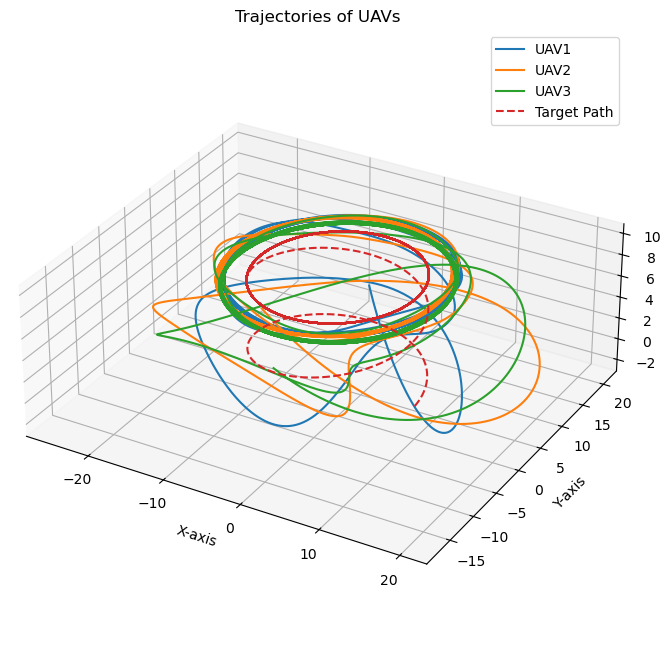

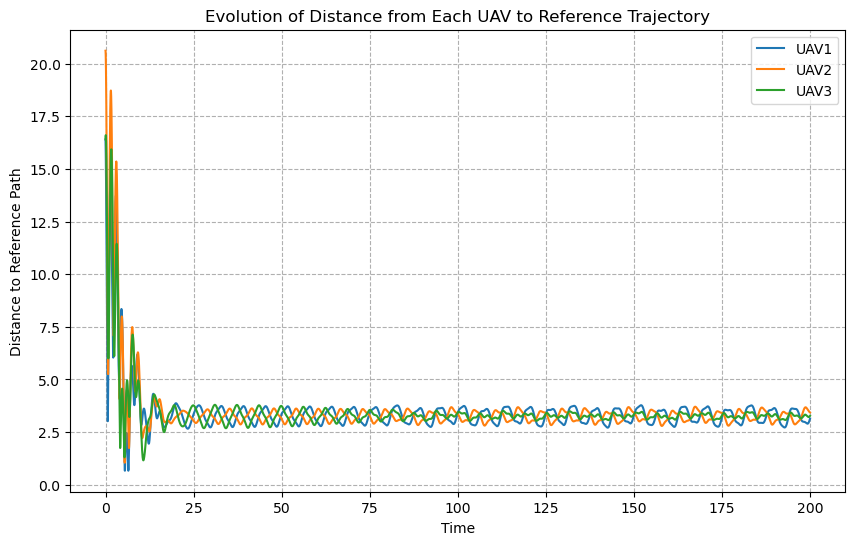

In [50]:
# Plot 3D trajectory for UAVs
fig1 = plt.figure(figsize=(10, 8))
ax1 = fig1.add_subplot(111, projection='3d')

# Adjust aspect ratio for a room-like appearance
ax1.set_box_aspect([np.ptp(arr) for arr in [xi1, yi1, zi1]])

ax1.plot(xi1, yi1, zi1, label='UAV1')
ax1.plot(xi2, yi2, zi2, label='UAV2')
ax1.plot(xi3, yi3, zi3, label='UAV3')
target_path = reference_signal(t_vals)
ax1.plot(target_path[0], target_path[1], target_path[2], label='Target Path', linestyle='--')

ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis')
ax1.set_zlabel('Z-axis')
ax1.legend()
ax1.set_title('Trajectories of UAVs')

# Display the first plot
plt.show()

# Plot distance from each UAV to the reference trajectory
fig2, ax2 = plt.subplots(figsize=(10, 6))

distance_uav1 = np.sqrt((xi1 - target_path[0])**2 + (yi1 - target_path[1])**2 + (zi1 - target_path[2])**2)
distance_uav2 = np.sqrt((xi2 - target_path[0])**2 + (yi2 - target_path[1])**2 + (zi2 - target_path[2])**2)
distance_uav3 = np.sqrt((xi3 - target_path[0])**2 + (yi3 - target_path[1])**2 + (zi3 - target_path[2])**2)

ax1.grid(True, linestyle='--')
ax2.grid(True, linestyle='--')
# ax3.grid(True, linestyle='--')

ax2.plot(t_vals, distance_uav1, label='UAV1')
ax2.plot(t_vals, distance_uav2, label='UAV2')
ax2.plot(t_vals, distance_uav3, label='UAV3')
ax2.set_xlabel('Time')
ax2.set_ylabel('Distance to Reference Path')
ax2.legend()
ax2.set_title('Evolution of Distance from Each UAV to Reference Trajectory')

# Display the second plot
plt.show()


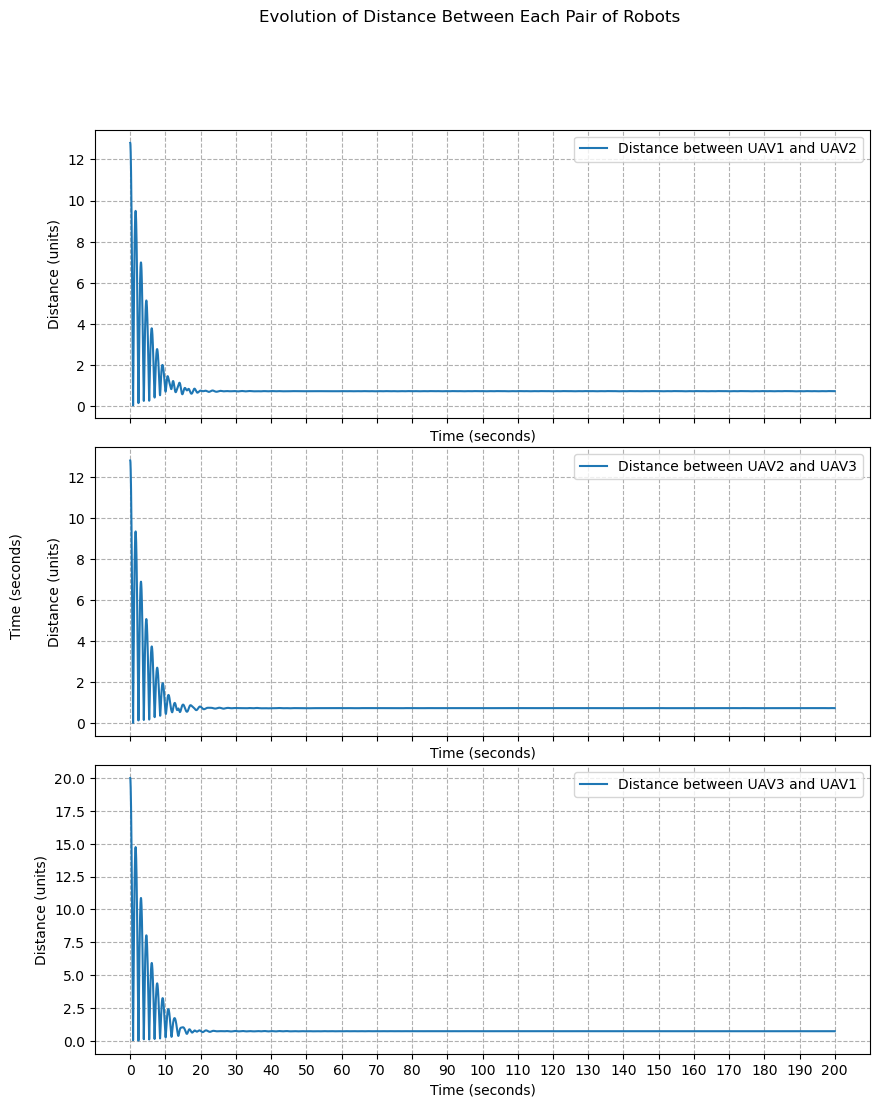

In [51]:
# Calculate distances between pairs of robots
distance_r12 = np.sqrt((xi1 - xi2)**2 + (yi1 - yi2)**2 + (zi1 - zi2)**2)
distance_r23 = np.sqrt((xi2 - xi3)**2 + (yi2 - yi3)**2 + (zi2 - zi3)**2)
distance_r31 = np.sqrt((xi3 - xi1)**2 + (yi3 - yi1)**2 + (zi3 - zi1)**2)

# Plot evolution of distances between each pair of robots
fig3, (ax_r12, ax_r23, ax_r31) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

ax_r12.grid(True, linestyle='--')
ax_r23.grid(True, linestyle='--')
ax_r31.grid(True, linestyle='--')

ax_r12.plot(t_vals, distance_r12, label='Distance between UAV1 and UAV2')
ax_r12.set_xlabel('Time (seconds)')
ax_r12.set_ylabel('Distance (units)')
ax_r12.legend()

ax_r23.plot(t_vals, distance_r23, label='Distance between UAV2 and UAV3')
ax_r23.set_xlabel('Time (seconds)')
ax_r23.set_ylabel('Distance (units)')
ax_r23.legend()

ax_r31.plot(t_vals, distance_r31, label='Distance between UAV3 and UAV1')
ax_r31.set_xlabel('Time (seconds)')
ax_r31.set_ylabel('Distance (units)')
ax_r31.legend()

# Set common x-axis ticks
plt.xticks(np.arange(min(t_vals), max(t_vals) + 1, 10))
plt.subplots_adjust(hspace=0.1)

# Set common y-axis label
fig3.text(0.04, 0.5, 'Time (seconds)', va='center', rotation='vertical')

# Add a common title
fig3.suptitle('Evolution of Distance Between Each Pair of Robots')

# Display the modified third plot
plt.show()



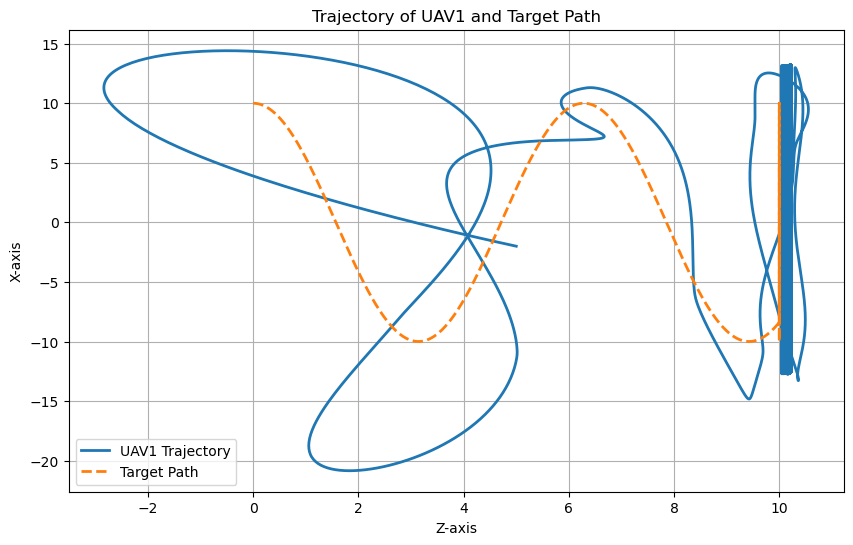

In [12]:
import matplotlib.pyplot as plt

# Assuming zi1 and xi1 are the trajectories of UAV1 in z and x axes
# Also assuming target_path is the target path for z and x axes

# Plot trajectory of UAV1 and target path
plt.figure(figsize=(10, 6))

# Plot UAV1 trajectory
plt.plot(zi1, xi1, label='UAV1 Trajectory', linewidth=2)

# Plot target path
plt.plot(target_path[2], target_path[0], label='Target Path', linestyle='--', linewidth=2)

# Set labels and title
plt.xlabel('Z-axis')
plt.ylabel('X-axis')
plt.title('Trajectory of UAV1 and Target Path')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


Solution and plots for with gps

In [26]:
import random
prev_error1 = np.zeros(3)
prev_error2 = np.zeros(3)
prev_error3 = np.zeros(3)


def system_dynamics_error(y, t, a1, b1, a_bar, b_bar, lambda_val, resf, rv, epsilon, K1, K2, prev_error1, prev_error2, prev_error3, noise):

    xi1, yi1, zi1, xi2, yi2, zi2, xi3, yi3, zi3, x_dot1, y_dot1, z_dot1, x_dot2, y_dot2, z_dot2, x_dot3, y_dot3, z_dot3  = y[:18]
    fr_x1, fr_y1, fr_z1 = 0, 0, 0
    fr_x2, fr_y2, fr_z2 = 0, 0, 0
    fr_x3, fr_y3, fr_z3 = 0, 0, 0
    # print(xi1, yi1, zi1)
    # print(prev_error1)

    # Calculate GPS error (variability of ±3 m)
    # gps_error_x = np.random.uniform(-0.5, 0.5)
    # gps_error_y = np.random.uniform(-0.5, 0.5)

    # # Apply GPS error to x and y coordinates
    print(xi1)
    xi1 += noise
    print(xi1)
    yi1 += noise
    xi2 += noise
    yi2 += noise
    xi3 += noise
    yi3 += noise

    # Calculate repulsion forces
    for neighbor in [(xi2, yi2, zi2), (xi3, yi3, zi3)]:
        fr_x, fr_y, fr_z = repulsion_force(xi1, yi1, zi1, *neighbor, rv)
        fr_x1 += fr_x
        fr_y1 += fr_y
        fr_z1 += fr_z

    for neighbor in [(xi1, yi1, zi1), (xi3, yi3, zi3)]:
        fr_x, fr_y, fr_z = repulsion_force(xi2, yi2, zi2, *neighbor, rv)
        fr_x2 += fr_x
        fr_y2 += fr_y
        fr_z2 += fr_z

    for neighbor in [(xi1, yi1, zi1), (xi2, yi2, zi2)]:
        fr_x, fr_y, fr_z = repulsion_force(xi3, yi3, zi3, *neighbor, rv)
        fr_x3 += fr_x
        fr_y3 += fr_y
        fr_z3 += fr_z


    # Perturbation forces (set to zero for now)
    fd_x1, fd_y1, fd_z1 = 0, 0, 0
    fd_x2, fd_y2, fd_z2 = 0, 0, 0
    fd_x3, fd_y3, fd_z3 = 0, 0, 0

    # Perturbation forces
    # fd_x1 = 10 + 10 * np.sin(0.2 * np.pi * (t - 80)) * (t >= 80)
    # fd_y1 = 5 + 5 * np.sin(0.2 * np.pi * (t - 140)) * (t >= 140)

    # fd_x2 = 10 + 10 * np.sin(0.2 * np.pi * (t - 80)) * (t >= 80)
    # fd_y2 = 5 + 5 * np.sin(0.2 * np.pi * (t - 140)) * (t >= 140)

    # fd_x3 = 10 + 10 * np.sin(0.2 * np.pi * (t - 80)) * (t >= 80)
    # fd_y3 = 5 + 5 * np.sin(0.2 * np.pi * (t - 140)) * (t >= 140)

    # fd_z1, fd_z2, fd_z3 = 0, 0, 0


    # Calculate sliding surface and control signals
    error1 = np.array([xi1, yi1, zi1]) - reference_signal(t)
    error2 = np.array([xi2, yi2, zi2]) - reference_signal(t)
    error3 = np.array([xi3, yi3, zi3]) - reference_signal(t)

    # Calculate error_dot
    error_dot1 = (error1 - prev_error1) / dt
    error_dot2 = (error2 - prev_error2) / dt
    error_dot3 = (error3 - prev_error3) / dt

    # print(error1, error2, error3)

    # Update previous errors for the next iteration
    prev_error1 = error1.copy()
    prev_error2 = error2.copy()
    prev_error3 = error3.copy()

    # Calculate sliding surface and control signals
    s_surface1 = lambda_val * error1 + error_dot1
    s_surface2 = lambda_val * error2 + error_dot2
    s_surface3 = lambda_val * error3 + error_dot3

    # Sliding mode control with saturation
    u_x1 = -K1 * s_surface1[0] - K2 * s_surface1[0] / np.linalg.norm(s_surface1) * saturation(s_surface1[0], epsilon)
    u_y1 = -K1 * s_surface1[1] - K2 * s_surface1[1] / np.linalg.norm(s_surface1) * saturation(s_surface1[1], epsilon)
    u_z1 = -K1 * s_surface1[2] - K2 * s_surface1[2] / np.linalg.norm(s_surface1) * saturation(s_surface1[2], epsilon)

    u_x2 = -K1 * s_surface2[0] - K2 * s_surface2[0] / np.linalg.norm(s_surface2) * saturation(s_surface2[0], epsilon)
    u_y2 = -K1 * s_surface2[1] - K2 * s_surface2[1] / np.linalg.norm(s_surface2) * saturation(s_surface2[1], epsilon)
    u_z2 = -K1 * s_surface2[2] - K2 * s_surface2[2] / np.linalg.norm(s_surface2) * saturation(s_surface2[2], epsilon)

    u_x3 = -K1 * s_surface3[0] - K2 * s_surface3[0] / np.linalg.norm(s_surface3) * saturation(s_surface3[0], epsilon)
    u_y3 = -K1 * s_surface3[1] - K2 * s_surface3[1] / np.linalg.norm(s_surface3) * saturation(s_surface3[1], epsilon)
    u_z3 = -K1 * s_surface3[2] - K2 * s_surface3[2] / np.linalg.norm(s_surface3) * saturation(s_surface3[2], epsilon)

    # Dynamics equations
    dx1dt = x_dot1
    dy1dt = y_dot1 
    dz1dt = z_dot1
    dvx1dt = -a1 * x_dot1 + b1 * (u_x1 + fr_x1 + fd_x1)
    dvy1dt = -a1 * y_dot1 + b1 * (u_y1 + fr_y1 + fd_y1)
    dvz1dt = -a_bar * z_dot1 + b_bar * (u_z1 + fr_z1 + fd_z1)

    dx2dt = x_dot2
    dy2dt = y_dot2
    dz2dt = z_dot2
    dvx2dt = -a1 * x_dot2 + b1 * (u_x2 + fr_x2 + fd_x2)
    dvy2dt = -a1 * y_dot2 + b1 * (u_y2 + fr_y2 + fd_y2)
    dvz2dt = -a_bar * z_dot2 + b_bar * (u_z2 + fr_z2 + fd_z2)

    dx3dt = x_dot3
    dy3dt = y_dot3
    dz3dt = z_dot3
    dvx3dt = -a1 * x_dot3 + b1 * (u_x3 + fr_x3 + fd_x3)
    dvy3dt = -a1 * y_dot3 + b1 * (u_y3 + fr_y3 + fd_y3)
    dvz3dt = -a_bar * z_dot3 + b_bar * (u_z3 + fr_z3 + fd_z3)


    return [dx1dt, dy1dt, dz1dt, dx2dt, dy2dt, dz2dt, dx3dt, dy3dt, dz3dt,
            dvx1dt, dvy1dt, dvz1dt, dvx2dt, dvy2dt, dvz2dt, dvx3dt, dvy3dt, dvz3dt]



In [30]:
# Now use this modified function in odeint
solution_with_gps_error = odeint(system_dynamics_error, initial_state, t_vals, args=(a1, b1, a_bar, b_bar, lambda_val, resf, rv, epsilon, K1, K2, prev_error1, prev_error2, prev_error3, np.random.uniform(-3,3)))

# Extract results
xi1_with_gps_error, yi1_with_gps_error, zi1_with_gps_error, xi2_with_gps_error, yi2_with_gps_error, zi2_with_gps_error, xi3_with_gps_error, yi3_with_gps_error, zi3_with_gps_error, _, _, _, _, _, _, _, _, _ = solution_with_gps_error.T


-2.0
-3.3897671539683163
-2.0
-3.3897671539683163
-1.9999999999535572
-3.3897671539218734
-1.9999999999071143
-3.3897671538754306
-1.9999999998606715
-3.3897671538289877
-1.9999930906795773
-3.389760244647894
-1.999993091352851
-3.3897602453211673
-1.9999724667987089
-3.389739620767025
-1.9999724681492599
-3.389739622117576
-1.9999381316104545
-3.3897052855787706
-1.9999381329690102
-3.3897052869373265
-1.9993693502149832
-3.3891365041832993
-1.9993693774993282
-3.3891365314676447
-1.9996647265008205
-3.389431880469137
-1.9996647359506412
-3.3894318899189573
-1.9999009033524064
-3.3896680573207227
-1.9999009037162008
-3.389668057684517
-1.999854948551826
-3.3896221025201423
-1.9998549481942622
-3.3896221021625785
-1.9998002677305153
-3.389567421698832
-1.999800267733075
-3.3895674217013916
-1.9997368637413244
-3.3895040177096405
-1.999736863744024
-3.3895040177123406
-1.999583890833465
-3.3893510448017814
-1.9995838908464205
-3.389351044814737
-1.9993960409053
-3.3891631948736163
-1.99

In [ ]:
# Integrate the system using odeint
solution = odeint(system_dynamics, initial_state, t_vals, args=(a1, b1, a_bar, b_bar, lambda_val, resf, rv, epsilon, K1, K2, prev_error1, prev_error2, prev_error3))

# Extract results
xi1, yi1, zi1, xi2, yi2, zi2, xi3, yi3, zi3, _, _, _, _, _, _, _, _, _ = solution.T


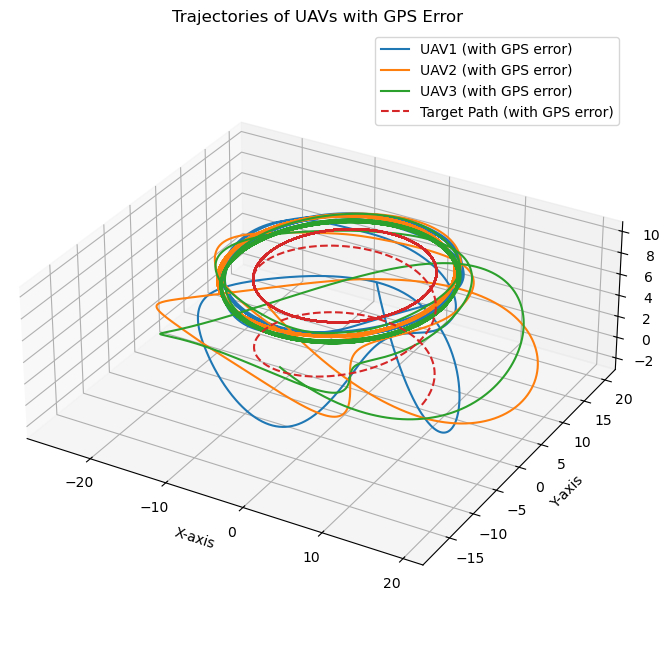

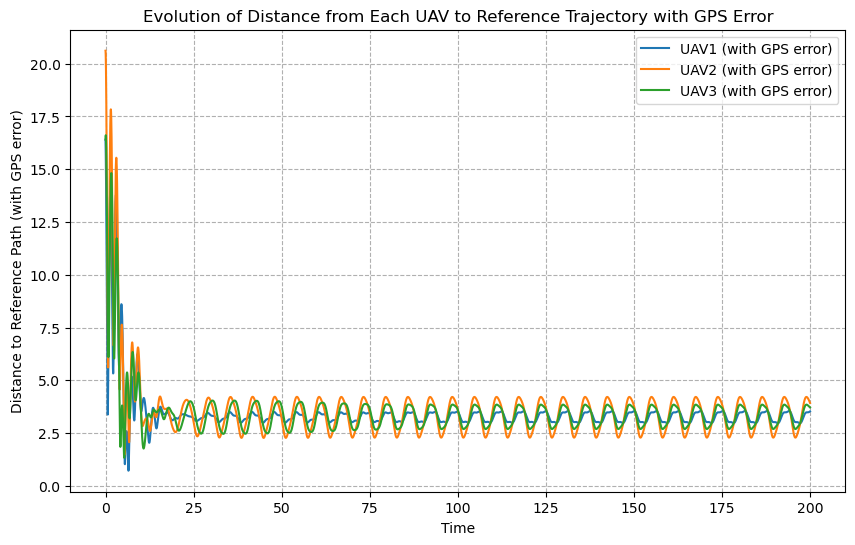

In [25]:
# Plot 3D trajectory for UAVs with GPS error
fig1_with_gps_error = plt.figure(figsize=(10, 8))
ax1_with_gps_error = fig1_with_gps_error.add_subplot(111, projection='3d')

# Adjust aspect ratio for a room-like appearance
ax1_with_gps_error.set_box_aspect([np.ptp(arr) for arr in [xi1_with_gps_error, yi1_with_gps_error, zi1_with_gps_error]])

ax1_with_gps_error.plot(xi1_with_gps_error, yi1_with_gps_error, zi1_with_gps_error, label='UAV1 (with GPS error)')
ax1_with_gps_error.plot(xi2_with_gps_error, yi2_with_gps_error, zi2_with_gps_error, label='UAV2 (with GPS error)')
ax1_with_gps_error.plot(xi3_with_gps_error, yi3_with_gps_error, zi3_with_gps_error, label='UAV3 (with GPS error)')
target_path = reference_signal(t_vals)
ax1_with_gps_error.plot(target_path[0], target_path[1], target_path[2], label='Target Path (with GPS error)', linestyle='--')

ax1_with_gps_error.set_xlabel('X-axis')
ax1_with_gps_error.set_ylabel('Y-axis')
ax1_with_gps_error.set_zlabel('Z-axis')
ax1_with_gps_error.legend()
ax1_with_gps_error.set_title('Trajectories of UAVs with GPS Error')

# Display the first plot with GPS error
plt.show()

# Plot distance from each UAV to the reference trajectory with GPS error
fig2_with_gps_error, ax2_with_gps_error = plt.subplots(figsize=(10, 6))

distance_uav1_with_gps_error = np.sqrt((xi1_with_gps_error - target_path[0])**2 + (yi1_with_gps_error - target_path[1])**2 + (zi1_with_gps_error - target_path[2])**2)
distance_uav2_with_gps_error = np.sqrt((xi2_with_gps_error - target_path[0])**2 + (yi2_with_gps_error - target_path[1])**2 + (zi2_with_gps_error - target_path[2])**2)
distance_uav3_with_gps_error = np.sqrt((xi3_with_gps_error - target_path[0])**2 + (yi3_with_gps_error - target_path[1])**2 + (zi3_with_gps_error - target_path[2])**2)

ax2_with_gps_error.grid(True, linestyle='--')

ax2_with_gps_error.plot(t_vals, distance_uav1_with_gps_error, label='UAV1 (with GPS error)')
ax2_with_gps_error.plot(t_vals, distance_uav2_with_gps_error, label='UAV2 (with GPS error)')
ax2_with_gps_error.plot(t_vals, distance_uav3_with_gps_error, label='UAV3 (with GPS error)')
ax2_with_gps_error.set_xlabel('Time')
ax2_with_gps_error.set_ylabel('Distance to Reference Path (with GPS error)')
ax2_with_gps_error.legend()
ax2_with_gps_error.set_title('Evolution of Distance from Each UAV to Reference Trajectory with GPS Error')

# Display the second plot with GPS error
plt.show()


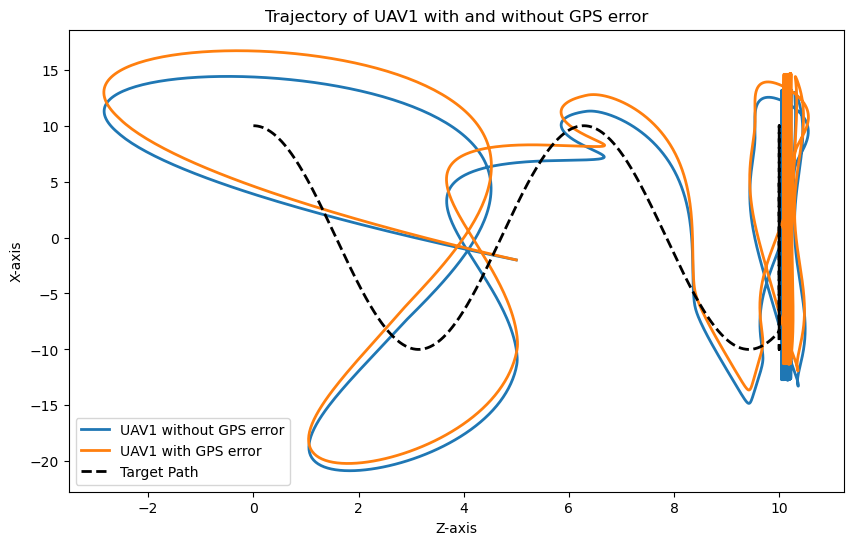

In [38]:
import matplotlib.pyplot as plt

# Assuming you have the trajectories for UAV1 with and without GPS error
# For example, xi1 and xi1_with_gps_error_noisy

# Plot trajectories
fig, ax = plt.subplots(figsize=(10, 6))

# Trajectory without GPS error
ax.plot(zi1, xi1, label='UAV1 without GPS error', linewidth=2)

# Trajectory with GPS error
ax.plot(zi1_with_gps_error, xi1_with_gps_error, label='UAV1 with GPS error', linewidth=2)

# Target path
target_path = reference_signal(t_vals)
ax.plot(target_path[2], target_path[0], label='Target Path', linestyle='--', color='black', linewidth=2)

# Set labels and title
ax.set_xlabel('Z-axis')
ax.set_ylabel('X-axis')
ax.legend()
ax.set_title('Trajectory of UAV1 with and without GPS error')

# Show the plot
plt.show()


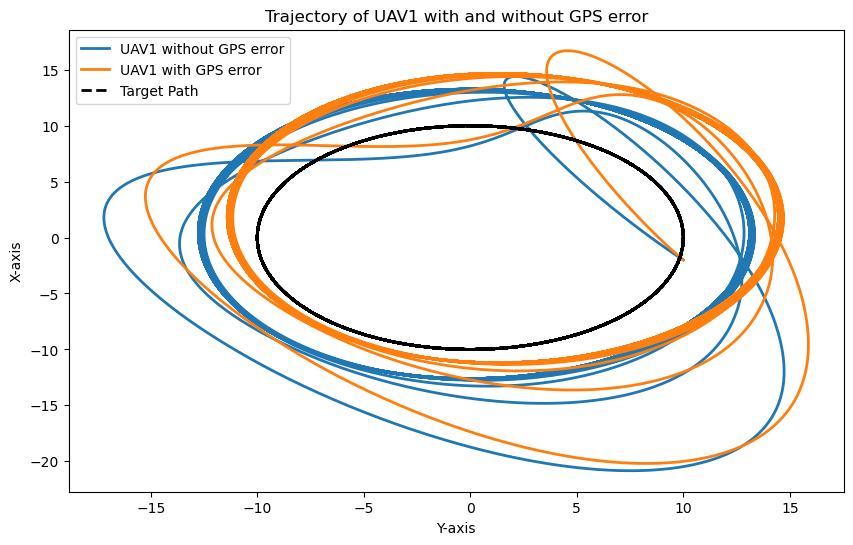

In [66]:
import matplotlib.pyplot as plt

# Assuming you have the trajectories for UAV1 with and without GPS error
# For example, xi1 and xi1_with_gps_error_noisy

# Plot trajectories
fig, ax = plt.subplots(figsize=(10, 6))

# Trajectory without GPS error
ax.plot(yi1, xi1, label='UAV1 without GPS error', linewidth=2)

# Trajectory with GPS error
ax.plot(yi1_with_gps_error, xi1_with_gps_error, label='UAV1 with GPS error', linewidth=2)

# Target path
target_path = reference_signal(t_vals)
ax.plot(target_path[1], target_path[0], label='Target Path', linestyle='--', color='black', linewidth=2)

# Set labels and title
ax.set_xlabel('Y-axis')
ax.set_ylabel('X-axis')
ax.legend()
ax.set_title('Trajectory of UAV1 with and without GPS error')

# Show the plot
plt.show()


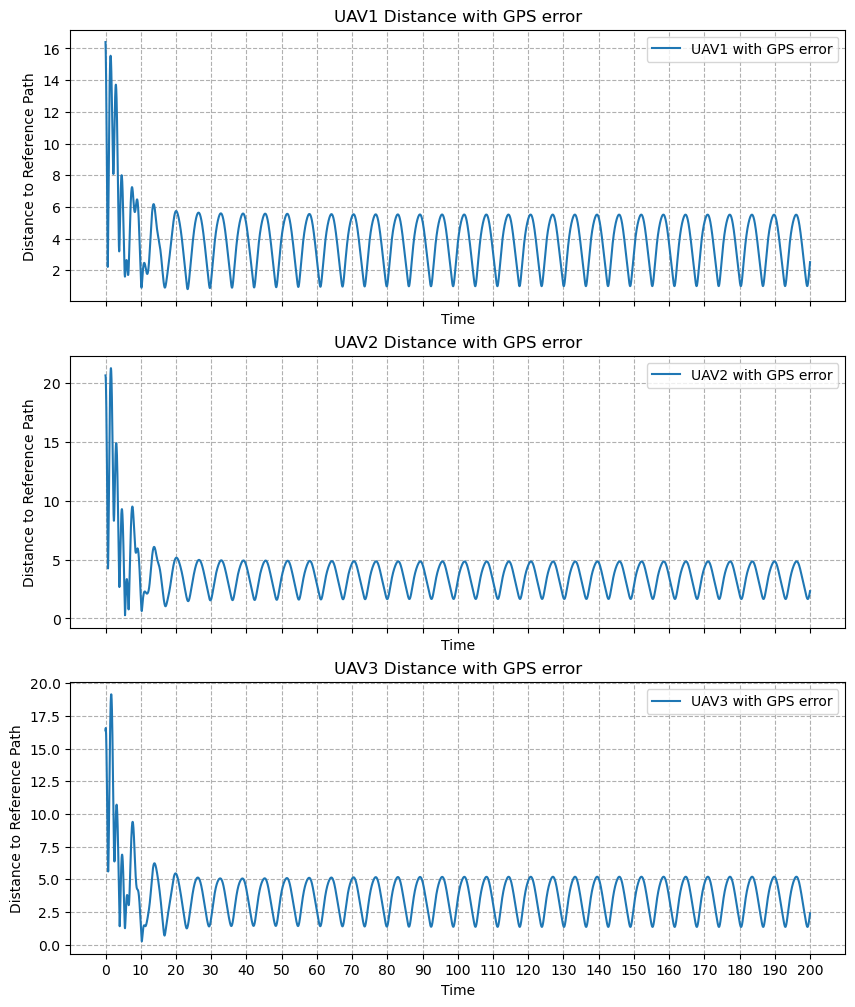

In [46]:
distances_with_gps_error1 = np.sqrt((xi1_with_gps_error - target_path[0])**2 + (yi1_with_gps_error - target_path[1])**2 + (zi1_with_gps_error - target_path[2])**2)
distances_with_gps_error2 = np.sqrt((xi2_with_gps_error - target_path[0])**2 + (yi2_with_gps_error - target_path[1])**2 + (zi2_with_gps_error - target_path[2])**2)
distances_with_gps_error3 = np.sqrt((xi3_with_gps_error - target_path[0])**2 + (yi3_with_gps_error - target_path[1])**2 + (zi3_with_gps_error - target_path[2])**2)

import matplotlib.pyplot as plt

# Assuming you have the distances with GPS error for UAVs
# For example, distances_with_gps_error1, distances_with_gps_error2, distances_with_gps_error3

# Plot distances with GPS error
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

ax1.grid(True, linestyle='--')
ax2.grid(True, linestyle='--')
ax3.grid(True, linestyle='--')

ax1.plot(t_vals, distances_with_gps_error1, label='UAV1 with GPS error')
ax1.set_xlabel('Time')
ax1.set_ylabel('Distance to Reference Path')
ax1.legend()
ax1.set_title('UAV1 Distance with GPS error')

ax2.plot(t_vals, distances_with_gps_error2, label='UAV2 with GPS error')
ax2.set_xlabel('Time')
ax2.set_ylabel('Distance to Reference Path')
ax2.legend()
ax2.set_title('UAV2 Distance with GPS error')


ax3.plot(t_vals, distances_with_gps_error3, label='UAV3 with GPS error')
ax3.set_xlabel('Time')
ax3.set_ylabel('Distance to Reference Path')
ax3.legend()
ax3.set_title('UAV3 Distance with GPS error')

# # Set x-ticks
# plt.xticks(ticks=np.arange(t_vals.min(), t_vals.max(), step=1000), labels=np.arange(t_vals.min(), t_vals.max(), step=1000))

# Set x-ticks
time_ticks = np.arange(0, t_vals.max() + 10, step=10)
ax3.set_xticks(time_ticks)

# Show the plot with GPS error
plt.show()
